# Multiple Linear Regression of Cryptocurrency

The following model I have developed to demonstrate how to extract, transform and load data and build a pipeline based on a Multiple Regression problem. I aim to forecast Bitcoin (C$) prices by extrapolating historical data, training, validating and testing the model before evaluating its accuracy using a benchmark score.

I am looking to predict the closing price (dependent variable) based on its relationship with other intraday price and volume information (independent variables).

## Performance Measure Selection
For the purpose of a multiple regression I am selecting the Root Mean Square Error (RMSE) to measure the overall degree of error when making model my predictions. 

$$ RMSE(X,h) = \sqrt {\frac{1}{m} \sum_{i=1}^{m}(h(x^ {i})-y^ {i})^2} $$

In [1]:
import pandas as pd
import numpy as np
import os
import tarfile
import urllib

DOWNLOAD_URL = "https://ca.finance.yahoo.com/quote/BTC-CAD/history?p=BTC-CAD"
BITCOIN_PATH = os.path.join("C:/Users/lynst/Documents/GitHub/machine-learning-projects/machine-learning/BTC_CAD.csv")
BITCOIN_URL = DOWNLOAD_URL + "C:/Users/lynst/Documents/GitHub/machine-learning-projects/machine-learning/BTC_CAD.csv"

def fetch_bitcoin_data(bitcoin_url=BITCOIN_URL, bitcoin_path=BITCOIN_PATH):
    os.makedirs(bitcoin_path, exist_ok=True)
    tgz_path = os.path.join(bitcoin_path)
    urllib.request.urlretrieve(bitcoin_url, tgz_path)
    bitcoin_tgz = tarfile.open(tgz_path)
    bitcoin_tgz.extract_all(path=bitcoin_path)
    bitcoin_tgz.close()
    
def load_bitcoin_data(bitcoin_path=BITCOIN_PATH):
    csv_path = os.path.join(bitcoin_path)
    return pd.read_csv(csv_path)

Start by loading the Canadian denominated Bitcoin data below.

In [2]:
btc_cad = load_bitcoin_data()

Each column represents a different feature, for example 'High', 'Low' and 'Close' prices are all features. These features are also known as attributes, input, or predictor variables which can be used to ascertain a stock price prediction (called labels, output, or target variables).

In [3]:
# get stock info
print(btc_cad.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       366 non-null    object 
 1   Open       362 non-null    float64
 2   High       362 non-null    float64
 3   Low        362 non-null    float64
 4   Close      362 non-null    float64
 5   Adj Close  362 non-null    float64
 6   Volume     362 non-null    float64
dtypes: float64(6), object(1)
memory usage: 20.1+ KB
None


The following method gives a breakdown of the first and last entries in the dataset.

In [4]:
btc_cad.info

<bound method DataFrame.info of            Date      Open      High       Low     Close  Adj Close  \
0    2020-04-21   9718.07   9838.33   9728.25   9763.94    9763.94   
1    2020-04-22   9762.68  10125.87   9747.39  10096.28   10096.28   
2    2020-04-23  10102.09  10533.73  10009.76  10451.16   10451.16   
3    2020-04-24  10457.43  10678.71  10457.43  10642.81   10642.81   
4    2020-04-25  10642.22  10773.18  10601.61  10669.64   10669.64   
..          ...       ...       ...       ...       ...        ...   
361  2021-04-17  76964.70  78268.41  75503.00  75906.36   75906.36   
362  2021-04-18  75928.95  76373.72  66081.83  70374.91   70374.91   
363  2021-04-19  70344.11  71803.61  68107.27  69788.23   69788.23   
364  2021-04-20       NaN       NaN       NaN       NaN        NaN   
365  2021-04-21  71509.30  71556.76  71132.08  71477.76   71477.76   

           Volume  
0    4.624843e+10  
1    4.716635e+10  
2    6.119120e+10  
3    4.881932e+10  
4    4.643028e+10  
..     

## Data Preprocessing
### Overall Statistics
Using the describe() method to view summary statistics helps define the average values or range of data involved in this dataset, as well as a measure of dispersion about its mean.

In [5]:
btc_cad.describe()

,Open,High,Low,Close,Adj Close,Volume
count,362.000000,362.000000,362.000000,362.000000,362.000000,3.620000e+02
mean,29707.219227,30555.675387,28874.214006,29864.750829,29864.750829,5.364938e+10
std,21773.553828,22482.286402,20992.768212,21845.825531,21845.825531,3.297456e+10
min,9718.070000,9838.330000,9728.250000,9763.940000,9763.940000,1.663903e+10
25%,13373.917500,13684.485000,13056.075000,13421.037500,13421.037500,3.142625e+10
50%,16520.155000,17169.830000,16253.260000,16921.560000,16921.560000,4.716901e+10
75%,44679.117500,46686.912500,41998.325000,45279.530000,45279.530000,6.929678e+10
max,79623.850000,81445.670000,77726.050000,79598.410000,79598.410000,4.470000e+11


So I can tell the average closing price is C$29,865 to the nearest integer. 

There isn't much data to work from (one years worth exactly), but I would like to create a dataframe object from the price data and try and use it to forecast future price information. Taking a look at which columns are present in the dataset gives me:

In [6]:
btc_cad.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

And now lets see the first and last 5 entries in the table:

In [7]:
btc_cad.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-04-21,9718.07,9838.33,9728.25,9763.94,9763.94,4.624843e+10
1,2020-04-22,9762.68,10125.87,9747.39,10096.28,10096.28,4.716635e+10
2,2020-04-23,10102.09,10533.73,10009.76,10451.16,10451.16,6.119120e+10
3,2020-04-24,10457.43,10678.71,10457.43,10642.81,10642.81,4.881932e+10
4,2020-04-25,10642.22,10773.18,10601.61,10669.64,10669.64,4.643028e+10


And now the tail of the dataframe.

In [8]:
btc_cad.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
361,2021-04-17,76964.70,78268.41,75503.00,75906.36,75906.36,8.272967e+10
362,2021-04-18,75928.95,76373.72,66081.83,70374.91,70374.91,1.220000e+11
363,2021-04-19,70344.11,71803.61,68107.27,69788.23,69788.23,8.183693e+10
364,2021-04-20,NaN,NaN,NaN,NaN,NaN,NaN
365,2021-04-21,71509.30,71556.76,71132.08,71477.76,71477.76,8.495634e+10


## Cleaning the Data
A brief look at the summary info for the dataset tells me there are a different number of date values compared to the rest of the column entries. This will need to be addressed, followed by any missing values, NaN, 'isnull' or entries with 'zero'. I can also see the different number 'count' for entries using the count() method:

In [9]:
btc_cad.count()

Date         366
Open         362
High         362
Low          362
Close        362
Adj Close    362
Volume       362
dtype: int64

First I just want to see what shape the dataframe is.

In [10]:
btc_cad.shape

(366, 7)

So it's 366 rows by 7 columns or a (366x7) matrix. Next, to find the total number of missing entries.

In [11]:
bitcoin_missing_values_count = btc_cad.isnull().sum()
bitcoin_missing_values_count[0:7]

Date         0
Open         4
High         4
Low          4
Close        4
Adj Close    4
Volume       4
dtype: int64

Further examination allows me to calculate the total number of rows containing missing data points as a percentage of the total number of rows in the dataframe.

In [12]:
total_bitcoin = np.product(btc_cad.shape)
total_missing_bitcoin = bitcoin_missing_values_count.sum()

percent_missing_values = (total_missing_bitcoin/total_bitcoin) * 100
print(percent_missing_values)

0.936768149882904


From this I can see that just under 1% of the total values are missing. I can either choose to leave them out completely (as they may not really affect my model for the purpose of this exercise) or use imputed values such as the mean or median.

### Removing Rows
Having checked the csv file I can determine that there is no real reason for the missing values (null entries) for these dates. At first I thought these missing values might be due to public holidays but because Bitcoin is a currency, it appears to be traded OTC (Over The Counter) beyong normal trading hours throughout the day, seven days a week. As a result I have chosen to leave these missing values out using the dropna() method to eliminate them. This should provide a total of 162 rows.

In [13]:
# dropping the rows with missing or 'na' entries using 'axis=0' for the row dimension
btc_cad = btc_cad.dropna(axis=0)

# finding the new row count
btc_cad.count()

Date         362
Open         362
High         362
Low          362
Close        362
Adj Close    362
Volume       362
dtype: int64

This time there are exactly 362 rows for each column. It's important to set the argument (axis=0) otherwise dropping the values doesn't work. 

### Removing Columns (Feature Selection)

The values in the 'Adj Close' column are exactly the same as in the 'Close' column so I will remove 'Adj Close' completely from the dataset in an attempt to regularize the model. This is unecessary data which can be removed as it could contribute to bias and bleed into the test data. It's better to reduce the overall number of variables particularly removing those which are not relevant (the process of regularization to simplify the model and avoid overfitting).

In [14]:
btc_cad.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

In [15]:
del btc_cad['Adj Close']

In [16]:
btc_cad.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume'], dtype='object')

Next, I will store the independent variables (features) in a Pandas dataframe called bitcoin which can be used for further analysis.

In [17]:
print(type(btc_cad))

<class 'pandas.core.frame.DataFrame'>


# Exploratory Data Analysis

The mean value for the Bitcoin (CAD) close price is C$ 29,864.75 and from the summary statistics using 'describe()' I can also see the maximum values in the upper-quartile range have been tested regularly.

As there are no dividends or stock splits because Bitcoin is a currency (medium of exchange / store of value), only 6 columns are of any use to me in this particular dataset: Date, Open, High, Low, Close and Volume. Printing the first 5 lines of the dataframe gives:

In [18]:
print(btc_cad[:5])

         Date      Open      High       Low     Close        Volume
0  2020-04-21   9718.07   9838.33   9728.25   9763.94  4.624843e+10
1  2020-04-22   9762.68  10125.87   9747.39  10096.28  4.716635e+10
2  2020-04-23  10102.09  10533.73  10009.76  10451.16  6.119120e+10
3  2020-04-24  10457.43  10678.71  10457.43  10642.81  4.881932e+10
4  2020-04-25  10642.22  10773.18  10601.61  10669.64  4.643028e+10


Storing the btc_cad dataframe in a new variable called 'bitcoin'

In [19]:
bitcoin = btc_cad

## Visualizing the Data
Let's take a look at plotting the different price data over time. This first plot will have the different OHLC prices for the last year. For the purpose of displaying this particular line plot I will remove the 'Adj close' because it's not needed and the 'Volume' feature as the scale is completely different to that of the OHLC prices.

<AxesSubplot:title={'center':'Daily Bitcoin OHLC Prices in $CAD'}, xlabel='Date'>

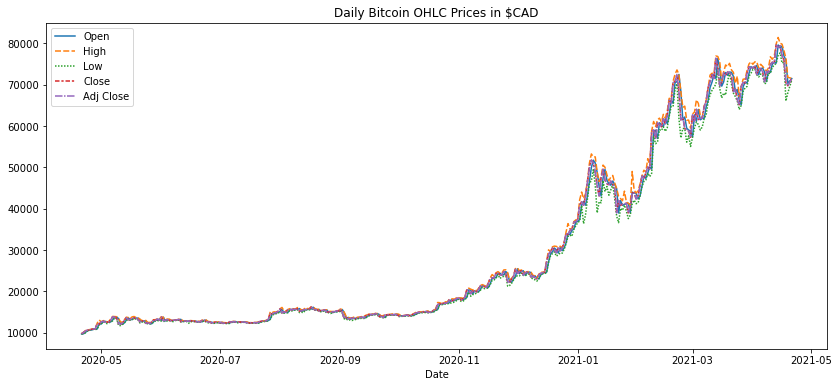

In [21]:
# Import the necessary libraries
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Location of the file path
bitcoin_path = os.path.join("C:/Users/lynst/Documents/GitHub/machine-learning-projects/machine-learning/BTC_CAD.csv")

# Open the file into a variable bitcoin
bitcoin = pd.read_csv(bitcoin_path, index_col="Date", parse_dates=True)

# removing the 'Adj close' and 'Volume' columns
del bitcoin['Adj del bitcoin['Volume']

# Plot the width and height of the figure
plt.figure(figsize=(14,6))

# Add a decsriptive title
plt.title("Daily Bitcoin OHLC Prices in $CAD")

# Line chart showing daily global streams of each song 
sns.lineplot(data=bitcoin)

At first glance I can detect an underlying trend for the price of Bitcoin, but there is also a noticable spike in Feb 2021 before reverting back to the trend. This makes the price data easier to read once the width and height of the axes have been adjusted. If I want to create a subplot of the 'Close' price (as the target variable I will eventually use), then I may decide to list the columns first:

In [ ]:
list(bitcoin.columns)

In [ ]:
# Once again setting the width and height of the figure
plt.figure(figsize=(14,6))

# Add title
plt.title("Daily Bitcoin Close Price in $CAD")

# Line chart showing daily 'Close'
sns.lineplot(data=bitcoin['Close'], label="Close")

# Add label for horizontal axis
plt.xlabel("Date")

So as we can see there is a definite gradual upward trend. In this particular instance the plot exhibits a price pattern called an 'ascending triangle' which is a term used by technical analysts. This term can be used to make buying and selling decisions based on the shape of the pattern.

## Correlation (Multivariate Stats)
The first stage of any feature selection process for a linear regression model should involve checking multivariate statistics and the degree of correlation between the features and also with the target variable. (Be careful and perform the correlation function on 'bitcoin' dataframe, not the 'data' dictionary. This multivariate statistic is essential to avoid poor performance as high correlations between variables can prevent the model's loss function from converging to the global minimum.

In [ ]:
correlation = bitcoin.corr()
print(correlation)

I would expect the opening and closing prices to be defined by the range of the high and low daily prices so all of these values tend to move within a fairly narrow band. There is a strong degree of positive correlation between these time-series values. I can also determine there is a less powerful degree of association between the volume of currency traded and its closing price (0.582709), but a positive relationship nonetheless. 

 Assuming I wanted to find the top three highest correlated features I could use the .abs() and .nlargest() methods:

In [ ]:
print(bitcoin.corr().abs().nlargest(3, 'Close').index)          # to find the top 3 features with highest correlation values

In [ ]:
print(bitcoin.corr().abs().nlargest(3, 'Close').values[:,3])         # top 3 correlation values

Firstly, the perfectly correclated value of 1.0 represents the 'Close' price correlation with itself, but the nest two correlation values of 0.99918803 and 0.99873489 represent those of the daily 'High' and 'Low' resepectively.

Remember, this would only be necessary if I wanted to include only those features with the top 3 correlation scores. For the purpose of this model that would be the open, high and low prices but I want to include the volume also and have decided to keep all 4 features. Next I intend to look at a scatter plot to show the relationship between some of these variables starting with the daily high and close prices.

In [ ]:
plt.scatter(bitcoin['High'], bitcoin['Close'], marker='o')
plt.xlabel('High')
plt.ylabel('Close')
plt.show()

plt.scatter(bitcoin['Low'], bitcoin['Close'], marker='o', color='green')
plt.xlabel('Low')
plt.ylabel('Close')
plt.show()

plt.scatter(bitcoin['Open'], bitcoin['Close'], marker='o', color='orange')
plt.xlabel('Open')
plt.ylabel('Close')
plt.show()

A strong positive linear relationship exists between the High, Low and Open prices with the Close but the degree of correlation decreases with High, Low and Open prices respectively. Also this can be checked against the 4th row of the correlation matrix under the row with 'Close' in the entry.

And finally the relationship plot of daily volume against the closing prices. I can see there is one outlier on the right hand side.

In [ ]:
plt.scatter(bitcoin['Volume'], bitcoin['Close'], marker='o', color='coral')
plt.xlabel('Volume')
plt.ylabel('Close')
plt.show()

So there definitely is a relationship between 'Volume' and 'Close' but it doesn't appear to be very linear. It's all confined to a group with an outlier around the C$60,000 mark which likely represents the period that prices spiked due to a huge increase in the volume of contracts traded. Another problem I can see on the plot is the scale of the axis containing the 'Volume' values which indicates the need for feature normalization to address any adverse effects these values might have on the model training process.

## Feature Normalization
I first need to define the values of the numeric columns in the dataset to a common scale using MinMaxScaler(). 

In [ ]:
import pandas as pd
from sklearn import preprocessing

# Location of the file path
bitcoin_path = os.path.join("C:/Users/lynst/Documents/GitHub/machine-learning-projects/machine-learning/BTC_CAD.csv")

# Open the file into a variable bitcoin
bitcoin = pd.read_csv(bitcoin_path).dropna(axis=0)

# remove feature with string values - Date
del bitcoin['Date']

# check dataset now
print(bitcoin)

This transformation will shift the values to a range between 0 and 1 for each column. 

In [ ]:
# assign bitcoin dataset to df
df = bitcoin.dropna(axis=0)

# convert entries to float type
X = df.values.astype(float)

# define min max scaler
min_max_scaler = preprocessing.MinMaxScaler()

# transform data
X_scaled = min_max_scaler.fit_transform(X)

# 
df = pd.DataFrame(X_scaled, columns=df.columns)
print(df)

## Price Frequency Distributions and Data Dispersion

Taking a look at the frequency distributions of the different prices can tell me about their distributions about the average.

I know that earlier in the timeframe captured there were a large number of cumulative values within the ten to twenty thousand dollar range. The extra weighting given to these observations have obviously caused a fairly low mean value of approximately thirty thousand dollars, but the cryptocurrency finished up at 71.5 thousand dollars by April 2021. The overall range of price values has been divided into 20 separate bins for some clarity, so I can view the frequency or number of daily prices that fall within each interval category price range or bin.

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import style
import seaborn as sns

# create style
style.use("seaborn-darkgrid")

# set width and height
plt.figure(figsize=(10,6))

# Add a title
plt.title("Histogram of 'Close' Prices")

# Show the average daily closing price
sns.histplot(data=bitcoin, x=bitcoin['Close'], bins=20, color='darkturquoise')

# Add labels for both axes
plt.xlabel('Close Price')
plt.ylabel('Count')

Storing these values in a dataframe series and applying the mean method requires a few steps.

In [ ]:
# create filepath for dataset
btc_cad_path = os.path.join("C:/Users/lynst/Documents/GitHub/machine-learning-projects/machine-learning/BTC_CAD.csv")

# create a dict and then store a single column as a dataframe
data = {'Open': bitcoin['Open'],
        'High': bitcoin['High'],
        'Low': bitcoin['Low'],
        'Close': bitcoin['Close']}

df = pd.DataFrame(data, columns = ['Close'])

print(df)
print (type(df))

Next, converting the DataFrame column to a Series using the squeeze() method:

In [ ]:
close_series = df['Close'].squeeze()

print(close_series)
print (type(close_series))

So, now the 'dataframe' column has been converted to a 'series' data type, I aim to find the mean of the values for 'Close' prices over the period in question and display their frequency distribution.

In [ ]:
# create style
style.use("seaborn-whitegrid")

# print the mean value
print(close_series.mean())

# configure the plot size
plt.figure(figsize=(10,6))

# create a title
plt.title("Frequency Distribution of Mean 'Close' Prices")

# plot the series
close_plot = sns.distplot(close_series, bins=20, color='red')

The mean value is to the right of the peak on the frequency curve with a long tail containing values toward C$90,000 which exhibits positive skewness. 

The frequency distribution plots for the open, high, low and daily volume not only explain the range of values and the dispersion about the mean, but they also be some indication of how prices might revert back to some long term average. It would be foolish to assume that Bitcoin prices will continue the current upward trend beyond C$80,000 because the average is so low.

In [ ]:
# create style
style.use("seaborn-whitegrid")

# set width and height
plt.figure(figsize=(10,6))

# Add a title
plt.title("Frequency Distribution of 'Open' Prices")

# Show the average daily high price
sns.histplot(data=bitcoin, x=bitcoin['Open'], bins=20, color='turquoise')

# Add labels for both axes
plt.xlabel('Open Price')
plt.ylabel('Count')

In [ ]:
# create style
style.use("seaborn-whitegrid")

# set width and height
plt.figure(figsize=(10,6))

# Add a title
plt.title("Frequency Distribution of 'High' Prices")

# Show the average daily high price
sns.histplot(data=bitcoin, x=bitcoin['High'], bins=20, color='turquoise')

# Add labels for both axes
plt.xlabel('Daily High')
plt.ylabel('Count')

In [ ]:
# create style
style.use("seaborn-whitegrid")

# set width and height
plt.figure(figsize=(10,6))

# Add a title
plt.title("Frequency Distribution of 'Low' Prices")

# Show the average daily low price
sns.histplot(data=bitcoin, x=bitcoin['Low'], bins=20, color='turquoise')

# Add labels for both axes
plt.xlabel('Daily Low')
plt.ylabel('Count')

In [ ]:
# create style
style.use("seaborn-whitegrid")

# set width and height
plt.figure(figsize=(10,6))

# Add a title
plt.title("Frequency Distribution of Daily Volume")

# Show the average daily volume
#sns.histplot(data=bitcoin, x=bitcoin['Volume'], bins=20, color='limegreen')
sns.kdeplot(data=bitcoin, x=bitcoin['Volume'], color='limegreen', shade=True)

# Add labels for both axes
plt.xlabel('Volume')
plt.ylabel('Count')

The bulk of the daily volume of transactions rarely exceeds 100 billion but there are a few exceptions. 

Given the mean values for OHLC prices, another way to find out how many values are above or below the average would be:

In [ ]:
bitcoin['Open'].loc[bitcoin['Open'] > 29707.22]

In [ ]:
tot_o = (121 / 162) * 100
print(tot_o)

In [ ]:
bitcoin['High'].loc[bitcoin['High'] > 30555.68]

So there are 121 values greater than the mean daily opening price. Calculating this as a percentage of the total number of observations gives:

In [ ]:
tot_h = (123 / 162) * 100
print(tot_h)

Repeating this step for the other price attributes gives:

In [ ]:
bitcoin['Low'].loc[bitcoin['Low'] > 28874.21]

In [ ]:
tot_l = (122 / 162) * 100
print(tot_l)

In [ ]:
bitcoin['Close'].loc[bitcoin['Close'] > 29864.75]

In [ ]:
tot_c = (121 / 162) * 100
print(tot_c)

I can tell for all of these price categories that roughly 75% of the values lie above the mean which is another way to show their frequency distributions are positively skewed.

# Model Selection (Linear Regression)
## Training the Data
Next I want to split the data into predictors and a target variable, containing all my feature columns in one matrix or dataframe variable (X) and the target variable in a column vector (y). The prediction target can be assigned as follows:

In [ ]:
# import libraries
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# import data
bitcoin = pd.read_csv("C:/Users/lynst/Documents/GitHub/machine-learning-projects/machine-learning/BTC_CAD.csv")
df = pd.DataFrame(bitcoin).dropna(axis=0)

Checking the data in the first couple of rows:

In [ ]:
df.head(2)

In [ ]:
print(df)

In [ ]:
# all column names
df.columns

In [ ]:
# all column data types
df.dtypes

Assign the dependant, or y variable for the modelling process.

In [ ]:
y = df['Close']
print(y)

The features are a selection of columns used to predict 'y', also known as the independent variables. I am choosing to leave the 'Date' and 'Adj Close' columns out of this dataframe.

Note, I can either store the individual features in a variable which can be referenced or called when performing some function, or I can store the exact feature names as a list in the dataframe. For example:

In [ ]:
bitcoin_features = ['Open','High','Low','Volume']
print(bitcoin_features)

In [ ]:
# select features
X = df[bitcoin_features]
print(X)

In [ ]:
# an alternative way
X = df[["Open", "High", "Low", "Volume"]]
print(X)

A couple of important things to note here. Firstly because I already dropped not-available row entries (3), there are 362 correct entries spanning 365 rows which is correct. I don't need to perform this dropna() method on X and y individually because I have already applied this operation to the dataframe (df).

Secondly, I can see that referencing the features and storing them in a separate variable named 'bitcoin_features' really only comes in handy when there are a large number of features, perhaps too many to type into a list; but for the purpose of this exercise I prefer entering each feature name individually.

## Splitting the Data
Split the data into training and test sets with a 70-30 split but not without making a copy of the dataframe first.

In [ ]:
df = df.copy()

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

Printing out the shape of the training sets for both the X matrix and y vector gives:

In [ ]:
print(X_train.shape)
print(y_train.shape)

And the shape of the test data:

In [ ]:
print(X_test.shape)
print(y_test.shape)

So I can see that 253/362 * 100 = 70% and 109/362 * 100 = 30% for both the train and test sets respectively. Next I will save a copy of the dataframe to use.

In [ ]:
# instantiate model
linear_regression = LinearRegression()

# fit model
linear_regression.fit(X_train, y_train)

Now the 'training' data has been fit, try making a prediction on the first 5 values in the test set first.

In [ ]:
price_predictions = linear_regression.predict(X_test)
print("Predictions: ", linear_regression.predict(X_test.iloc[:5]))

Assume I want to make a prediction if the price of Bitcoin opens at 35000, has a daily high of 40000, a low of 32000 and trade volume of 100,000,000,000.

In [ ]:
# predicting price based on Open = C$35,000, High = C$40,000, Low = C$32,000 and Volume = 100bn
linear_regression.predict([[35000, 40000, 32000, 100000000000]])

## Metrics
So checking the values against the BTC_CAD.csv dataset I can see they are not exactly accurate. One way to check is introduce an accuracy score called MSE (mean squared error), but first I will check the R-squared measure to establish the overall degree of fit to the line.

In [ ]:
print("R-squared: ", linear_regression.score(X_test, y_test))

This is a fairly high score and I can see this relationship in a scatter plot showing actual prices against predicted prices.

In [ ]:
from sklearn.metrics import mean_squared_error
import numpy as np

mse = mean_squared_error(y_test, price_predictions)
print(mse)

rmse = np.sqrt(mse)
print(rmse)

# visualizing the relationship between actual and predicted values for y
plt.scatter(y_test, price_predictions)
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.title("Actual Prices vs Predicted Prices")

To find the intercept and coefficients:

In [ ]:
print(linear_regression.intercept_)
print(linear_regression.coef_)

## Applying Regularization
Now to see if I can improve on the linear regression model's ability to predict the target variable. I have decided to use Ridge Regression as a regularized form of linear regression. The regularization term helps reduce the parameter weights but this term is only used during the training phase so I need to remove it for evaluation purposes.

In [ ]:
# import libraries
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

# import data
bitcoin = pd.read_csv("C:/Users/lynst/Documents/GitHub/machine-learning-projects/machine-learning/BTC_CAD.csv")
df = pd.DataFrame(bitcoin).dropna(axis=0)

Checking the first 2 rows:

In [ ]:
df.head(2)

Assign the 'Close' prices to the dependent (target) variable.

In [ ]:
y = df["Close"]
print(y)

In [ ]:
# select features 
X = df[["Open", "High", "Low", "Volume"]]
print(X)

## Splitting the Data
Using a 70-30 split for the training and test sets.

In [ ]:
df = df.copy()

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

Printing out the shape of the training sets gives:

In [ ]:
print(X_train.shape)
print(y_train.shape)

And the shape of the test data:

In [ ]:
print(X_test.shape)
print(y_test.shape)

## Feature Engineering and Model Selection
### Ridge Regression
Trying a slightly different type of regression model using the alpha learning rate hyperparameter of 1.0 to see if I can reduce the (rmse) error value and increase the (r2) accuracy score. The purpose of using a ridge regression model is to try to reduce or eliminate the coefficient values of the various features.

In [ ]:
# instantiate model
ridge_regression = linear_model.Ridge(alpha=1.0)

# fit model
ridge_regression.fit(X_train, y_train)

Now the 'training' data has been fit, try making a prediction on the first 5 values in the test set first.

In [ ]:
price_predictions = ridge_regression.predict(X_test)
print("Predictions: ", ridge_regression.predict(X_test.iloc[:5]))

Now try a prediction by imputing my own values.

In [ ]:
# predicting price based on Open = C$35,000, High = C$40,000, Low = C$32,000 and Volume = 100bn
ridge_regression.predict([[35000, 40000, 32000, 100000000000]])

This tells me the prediction for the target output variable, y, based on the input variables specified and using ridge regression giving the value of C$37,990.99.

## Model Validation Metrics¶
Now to measure the error score and accuracy of the line of fit.

In [ ]:
print("R-squared: ", ridge_regression.score(X_test, y_test))

In [ ]:
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(y_test, price_predictions)
print(mse)

rmse = np.sqrt(mse)
print(rmse)

# visualizing the relationship between actual and predicted values for y
plt.scatter(y_test, price_predictions)
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.title("Actual Prices vs Predicted Prices")

In [ ]:
print(ridge_regression.intercept_)
print(ridge_regression.coef_)

This is a slight improvement on the original R-squared score and I can see that the RMSE hasn't really changed.
Trying to improve on the scores above, I decided to introduce a Polynomial model which should be able to fit the line more accurately to the data points.

# Evaluation
My first look at the results of the scores and their accuracy measures prompted me to re-visit the code and try and introduce more efficiency (reducing the number of lines), but also more consistency such as replicating similar steps for the use of different types of model. So even though I started storing the same dataset in different variables it can quickly become confusing and simultaneously very important to ensure similarity exists among the different models.

Initial linear regression rmse score = 689.1925598643533
R-squared accuracy = 0.9991392014437468

Ridge regression rmse score = 689.1925582115692
R-squared accuracy = 0.9991392014478754

So I can determine the use of ridge regression to regularize the model has produced a slight increase in overall variance but also a slightly more accurate prediction of the output.

In conclusion, the model requires a much larger dataset and would benefit from a larger time period of price information, perhaps dating back to it's initial inception (2010 - not that long ago). Because the dataset is too small it falls prey to 'Sampling Noise' which is the degree of error from sampling only one subsection of the population. The model could be improved if other sample sizes were used or if the entire population of data for Bitcoin prices was used. 

Regularization implies reducing the number of features or creating a more efficient use of feature engineering to counteract overfitting the data and should be applied to improve this problem. As well as more price data another way to achieve better generalization on unseen data may involve using features from substitute investments or alternative crypto-currencies. It might pay to include market indices relevant to the sector, or even some form of sentiment analysis from market news which could be interpreted numerically using a form of one-hot encoding. 

This model could potentially incorporate the risk from substitute investments (Dogecoin for example) which are direct competitors or alternative investments (such as Gold) which are a vital component of several investment portfolios, the risk associated with the industry or market sector, political risk associated with foreign and domestic policy, or even corporate risk associated with management level decisions such as whether or not Blockchain technology could be under threat of being potentially unravelled by Quantum computing. 

All of these components combined would no doubt provide a better overall picture and contribute to more accurate price discovery in the Crypto markets. Next, I will try to fit a forecast line using a Polynomial Regression model: 